In [1]:
!git clone https://github.com/LiyuanLucasLiu/RAdam.git
!python RAdam/setup.py install

Cloning into 'RAdam'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 306 (delta 11), reused 16 (delta 3), pack-reused 274
Receiving objects: 100% (306/306), 949.66 KiB | 2.00 MiB/s, done.
Resolving deltas: 100% (140/140), done.
running install
running bdist_egg
running egg_info
creating RAdam.egg-info
writing RAdam.egg-info/PKG-INFO
writing dependency_links to RAdam.egg-info/dependency_links.txt
writing requirements to RAdam.egg-info/requires.txt
writing top-level names to RAdam.egg-info/top_level.txt
writing manifest file 'RAdam.egg-info/SOURCES.txt'
reading manifest file 'RAdam.egg-info/SOURCES.txt'
writing manifest file 'RAdam.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying RAdam.egg-info/PKG

In [0]:
# imports
import os
import sys

import torch
import torch.nn as nn
from torch.utils import data
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from RAdam import radam

import numpy as np
import csv
import requests
import zipfile
import time
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
# class for download
class DataDownloader:

  def __init__(self, file_id, destination, download = True):
    self.file_id = file_id
    self.destination = destination

    if download:
      self.download_dataset()
      self.extract_zip()

  def download_dataset(self):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response):
        CHUNK_SIZE = 32768

        with open(self.destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : self.file_id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : self.file_id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response) 

  def extract_zip(self):
    if not os.path.exists('input'):
      os.makedirs('input')

    if not os.path.exists('output'):
      os.makedirs('output')

    if not os.path.exists('output/imgs'):
      os.makedirs('output/imgs')

    with zipfile.ZipFile(self.destination, 'r') as zip_ref:
      zip_ref.extractall('./input/')

In [0]:
FILE_ID = '1vy5tjrIw7sGtZrhe-lepUagV2stT1Tw4'
DST_LOC = './actor.zip'
DATA_IMAGES_DIR = './input/actor'
MODEL_SAVE_PATH = './output/model.pth'
SAVE_DIR = './output/'

data_download = DataDownloader(FILE_ID, DST_LOC, True)

In [0]:
class ImgDataset(data.Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.imgs_list = sorted(os.listdir(self.path))

    def __len__(self):
        return len(self.imgs_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(*(self.path, self.imgs_list[index])))

        if self.transform is not None:
            img = self.transform(img)

        return img

In [0]:
# helper def

def show_images(X):
    grid_sizes = {4: (2, 2),
                  8: (2, 4),
                  16: (4, 4),
                  32: (4, 8),
                  64: (8, 8),
                  128: (8, 16),
                  256: (16, 16),
                  512: (16, 32),
                  1024: (32, 32)}
    N = X.shape[0]
    size = grid_sizes.get(N, (1, N))

    imgs = (X.to('cpu').numpy().transpose(0, 2, 3, 1) + 1.)/2.
    img = merge_images(imgs, size)
    plt.figure()
    plt.imshow(img)


def imsave(X, path):
    # save the batch of images in X as a single image in path
    grid_sizes = {4: (2, 2),
                  8: (2, 4),
                  16: (4, 4),
                  32: (4, 8),
                  64: (8, 8),
                  128: (8, 16),
                  256: (16, 16),
                  512: (16, 32),
                  1024: (32, 32)}
    N = X.shape[0]
    size = grid_sizes.get(N, (1, N))

    imgs = (X.to('cpu').numpy().transpose(0, 2, 3, 1) + 1.)/2.
    img = merge_images(imgs, size)
    plt.figure()
    plt.imshow(img)
    plt.savefig(path)
    plt.close()

def merge_images(images, size):
    # merge a mini-batch of images into a single grid of images
    H, W, C = images.shape[1], images.shape[2], images.shape[3]
    merged_img = np.zeros((H * size[0], W * size[1], C))

    for idx, img in enumerate(images):
        i = idx // size[1]  # row number
        j = idx % size[1]   # column number

        merged_img[H * i: H * (i+1), W * j: W * (j+1), :] = img

    return merged_img

In [0]:
image_size = 64
batch_size = 128

shuffle = False
num_workers = 10
valid_split = 0.2

In [40]:
SetRange = transforms.Lambda(lambda X: 2*X - 1.)
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.Resize((image_size,
                                                   image_size)),
                                transforms.ToTensor(),
                                SetRange])

dataset = ImgDataset(DATA_IMAGES_DIR, transform=transform)

# create data indices for training and validation splits
dataset_size = len(dataset)  # number of samples in training + validation sets
indices = list(range(dataset_size))
split = int(np.floor(valid_split * dataset_size))  # samples in valid. set
np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=shuffle, num_workers=num_workers,
                                           sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=shuffle, num_workers=num_workers,
                                           sampler=valid_sampler)

print('{} samples for training'
      .format(int((1 - valid_split) * dataset_size)))
print('{} samples for validation'
      .format(int(valid_split * dataset_size)))

img_channels = dataset[0].shape[0]

38657 samples for training
9664 samples for validation


In [0]:
class Encoder(nn.Module):
    '''
    Variational Autoencoder: Encoder module.
    '''
    def __init__(self, in_channels, in_dim, latent_dim, filters,
                 kernel_sizes, strides, paddings, flat_dim,
                 activation=nn.LeakyReLU, batch_norm=True):
      
        super(Encoder, self).__init__()

        self.in_dim = in_dim
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.filters = filters
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.paddings = paddings
        self.flat_dim = flat_dim
        self.activation = activation
        self.batch_norm = batch_norm

        n_conv = len(self.filters)

        # first conv. layer
        conv_layers = nn.ModuleList([nn.Conv2d(self.in_channels,
                                               self.filters[0],
                                               self.kernel_sizes[0],
                                               stride=self.strides[0],
                                               padding=self.paddings[0])])
        if self.batch_norm:
            conv_layers.append(nn.BatchNorm2d(self.filters[0]))
        conv_layers.append(self.activation())

        # remaining conv. layers
        for i in range(1, n_conv):
            layer = nn.ModuleList([nn.Conv2d(self.filters[i-1],
                                             self.filters[i],
                                             self.kernel_sizes[i],
                                             stride=self.strides[i],
                                             padding=self.paddings[i])])
            if self.batch_norm:
                layer.append(nn.BatchNorm2d(self.filters[i]))
            layer.append(self.activation())
            conv_layers.extend(layer)

        # connect all conv. layers in a sequential block
        self.conv_block = nn.Sequential(*conv_layers)

        # define mean and variance layers
        self.mean_block = nn.Linear(self.flat_dim, self.latent_dim)
        self.logvar_block = nn.Linear(self.flat_dim, self.latent_dim)

        self.param_init()

    def param_init(self):
        '''Parameters initialization.'''
        for layer in self.modules():
            if hasattr(layer, 'weight'):
                if isinstance(layer, (nn.BatchNorm1d, nn.BatchNorm2d)):
                    nn.init.normal_(layer.weight, mean=1., std=0.02)
                else:
                    nn.init.xavier_normal_(layer.weight)
            if hasattr(layer, 'bias'):
                nn.init.constant_(layer.bias, 0.)

    def forward(self, X):
        '''Forward pass.'''
        h = self.conv_block(X)
        h = h.reshape(-1, self.flat_dim)
        z_mean = self.mean_block(h)
        z_logvar = self.logvar_block(h)

        return z_mean, z_logvar


class Decoder(nn.Module):
    '''Variational Autoencoder: Decoder module.'''
    def __init__(self, latent_dim, in_channels, in_dim, filters,
                 kernel_sizes, strides, paddings, out_paddings,
                 activation=nn.LeakyReLU, out_activation=nn.Tanh,
                 batch_norm=True):
      
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.in_dim = in_dim
        self.in_channels = in_channels
        self.filters = filters
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.paddings = paddings
        self.out_paddings = out_paddings
        self.activation = activation
        self.out_activation = out_activation
        self.batch_norm = batch_norm

        n_conv = len(self.filters)

        # input layer
        flat_dim = self.in_channels * (self.in_dim**2)
        input_layers = nn.ModuleList([nn.Linear(self.latent_dim, flat_dim)])
        if self.batch_norm:
            input_layers.append(nn.BatchNorm1d(flat_dim))
        input_layers.append(self.activation())

        self.input_block = nn.Sequential(*input_layers)

        # upsampling layers
        upsample_layers = nn.ModuleList([nn.ConvTranspose2d(
            self.in_channels,
            self.filters[0],
            self.kernel_sizes[0],
            stride=self.strides[0],
            padding=self.paddings[0],
            output_padding=out_paddings[0])])
        if self.batch_norm:
            upsample_layers.append(nn.BatchNorm2d(self.filters[0]))
        upsample_layers.append(self.activation())
        for i in range(1, n_conv):
            upsample_layers.append(nn.ConvTranspose2d(
                self.filters[i-1],
                self.filters[i],
                self.kernel_sizes[i],
                stride=self.strides[i],
                padding=self.paddings[i],
                output_padding=out_paddings[i]))

            if i < n_conv-1:
                if self.batch_norm:
                    upsample_layers.append(nn.BatchNorm2d(self.filters[i]))
                upsample_layers.append(self.activation())
            else:
                upsample_layers.append(self.out_activation())

        # connect all upsampling layers in a sequential block
        self.upsample_block = nn.Sequential(*upsample_layers)

        self.param_init()

    def param_init(self):
        for layer in self.modules():
            if hasattr(layer, 'weight'):
                if isinstance(layer, (nn.BatchNorm1d, nn.BatchNorm2d)):
                    nn.init.normal_(layer.weight, mean=1., std=0.02)
                else:
                    nn.init.xavier_normal_(layer.weight)
            if hasattr(layer, 'bias'):
                nn.init.constant_(layer.bias, 0.)

    def forward(self, z):
        h = self.input_block(z)
        h = h.reshape(-1, self.in_channels, self.in_dim, self.in_dim)
        Xrec = self.upsample_block(h)

        return Xrec


class VAE(nn.Module):
   
    def __init__(self, img_channels, img_dim, latent_dim, filters,
                 kernel_sizes, strides, activation=nn.LeakyReLU,
                 out_activation=nn.Tanh, batch_norm=True):
       
        super(VAE, self).__init__()

        self.img_dim = img_dim
        self.img_channels = img_channels
        self.latent_dim = latent_dim
        self.filters = filters
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.activation = activation
        self.out_activation = out_activation
        self.batch_norm = batch_norm

        n_conv = len(self.filters)

        # compute the paddings and the flattened dimension at the output of the
        # last conv.
        paddings = []
        dims = [self.img_dim]
        for i in range(n_conv):
            if (dims[i] - self.kernel_sizes[i]) % strides[i] == 0:
                paddings.append((self.kernel_sizes[i] - 1)//2)
            else:
                paddings.append((self.kernel_sizes[i] - strides[i] + 1)//2)

            dims.append((dims[i] + 2*paddings[i] - self.kernel_sizes[i])
                        // self.strides[i] + 1)
        flat_dim = self.filters[-1] * (dims[-1]**2)

        self.encoder = Encoder(self.img_channels, self.img_dim,
                               self.latent_dim, self.filters,
                               self.kernel_sizes, self.strides,
                               paddings, flat_dim,
                               activation=self.activation,
                               batch_norm=self.batch_norm)

        # the decoder architecture will be the transposed of the encoder's
        filters_dec = (list(reversed(self.filters[0:n_conv-1]))
                       + [img_channels])
        kernel_sizes_dec = list(reversed(self.kernel_sizes))
        strides_dec = list(reversed(self.strides))
        paddings = list(reversed(paddings))
        dims = list(reversed(dims))

        # compute the output paddings
        out_paddings = []
        for i in range(n_conv):
            out_dim = ((dims[i] - 1)*strides_dec[i] - 2*paddings[i] +
                       kernel_sizes_dec[i])
            out_paddings.append(dims[i+1] - out_dim)

        self.decoder = Decoder(self.latent_dim, self.filters[-1], dims[0],
                               filters_dec, kernel_sizes_dec, strides_dec,
                               paddings=paddings, out_paddings=out_paddings,
                               activation=self.activation,
                               out_activation=self.out_activation,
                               batch_norm=self.batch_norm)

    def sample(self, z_mean, z_logvar):
        eps = torch.randn_like(z_mean)
        z = z_mean + torch.exp(.5*z_logvar) * eps

        return z

    def forward(self, X):
        z_mean, z_logvar = self.encoder(X)
        z = self.sample(z_mean, z_logvar)
        Xrec = self.decoder(z)

        return Xrec, z_mean, z_logvar


def vae_loss(Xrec, X, z_mean, z_logvar, kl_weight=1e-3):

    reconst_ls = F.mse_loss(Xrec, X)
    kl_ls = torch.mean(-.5*torch.sum(1 + z_logvar - z_mean**2
                                     - torch.exp(z_logvar), dim=1), dim=0)

    loss = reconst_ls + kl_weight * kl_ls

    return loss, reconst_ls, kl_ls

In [0]:
training_loss = []
validation_loss = []

In [0]:
def train(vae, optimizer, train_loader, n_epochs, kl_weight=1e-3,
          valid_loader=None, n_gen=0):

    best_loss = 10000000.0

    # device = next(vae.parameters()).device
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))

        # training phase
        vae.train()  # training mode
        for i, X in enumerate(train_loader):
            X = X.to(device)

            # forward pass
            Xrec, z_mean, z_logvar = vae(X)

            # loss, backward pass and optimization step
            loss, reconst_loss, kl_loss = vae_loss(Xrec, X, z_mean, z_logvar,
                                                   kl_weight=kl_weight)
            optimizer.zero_grad()  # clear previous gradients
            loss.backward()        # compute new gradients
            optimizer.step()       # optimize the parameters

        # torch.save(vae.state_dict(), './models/vae.pth')

        # evaluation phase
        print()
        with torch.no_grad():
            vae.eval()  # inference mode

            # compute training loss
            train_loss = 0.
            for i, X in enumerate(train_loader):
                X = X.to(device)

                Xrec, z_mean, z_logvar = vae(X)
                train_loss += vae_loss(Xrec, X, z_mean, z_logvar,
                                       kl_weight=kl_weight)[0]

                # save original and reconstructed images
                if i == 0:
                    imsave(X, './output/imgs/train_orig.png')
                    imsave(Xrec, './output/imgs/train_rec.png')

            train_loss /= i + 1
            print('....train loss = {:.3f}'.format(train_loss.item()))
            training_loss.append(train_loss.item())

            if valid_loader is None:
                print()
            else:  # compute validation loss
                valid_loss = 0.
                for i, X in enumerate(valid_loader):
                    X = X.to(device)

                    Xrec, z_mean, z_logvar = vae(X)
                    valid_loss += vae_loss(Xrec, X, z_mean, z_logvar,
                                           kl_weight=kl_weight)[0]

                    # save original and reconstructed images
                    if i == 0:
                        imsave(X, './output/imgs/valid_orig.png')
                        imsave(Xrec, './output/imgs/valid_rec.png')

                valid_loss /= i + 1

                if valid_loss < best_loss:
                    # Save the model
                    torch.save(vae, MODEL_SAVE_PATH)
                    best_loss = valid_loss

                validation_loss.append(valid_loss.item())
                print('....valid loss = {:.3f}'.format(valid_loss.item()))
                print()

            # generate some new examples
            if n_gen > 0:
                z = torch.randn((n_gen, vae.latent_dim)).to(device)
                Xnew = vae.decoder(z)
                imsave(Xnew, './output/imgs/gen.png')


In [0]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
latent_dim = 128
kernel_sizes = [3, 3, 3, 3]
filters = [64, 128, 256, 512]
strides = [2, 2, 2, 2]
batch_norm = True
kl_weight = 1e-3

epochs = 50

In [79]:
vae = VAE(img_channels,
          image_size,
          latent_dim,
          filters,
          kernel_sizes,
          strides,
          activation=nn.LeakyReLU,
          out_activation=nn.Tanh,
          batch_norm=batch_norm).to(device)

vae.load_state_dict(torch.load('vae_celeba.pth'))

print(vae)

VAE(
  (encoder): Encoder(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
    )
    (mean_block): Linear(in_features=8192, out_features=128, bias=True)
    (logvar_bloc

In [0]:
optimizer = radam.RAdam(vae.parameters())

train(vae, optimizer, train_loader, 10, kl_weight=kl_weight,
      valid_loader=valid_loader, n_gen=batch_size)

In [0]:
log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
log_frame["Epoch"] = range(1, len(training_loss) + 1)
log_frame["Train Loss"] = training_loss
log_frame["Test Loss"] = validation_loss
log_frame.to_csv(os.path.join(SAVE_DIR, "log.csv"), index = False)

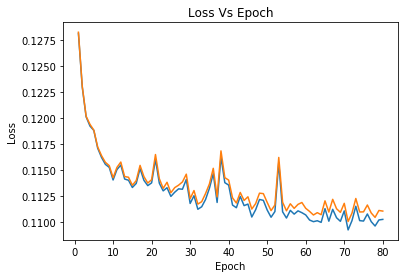

In [87]:
from matplotlib import style

from numpy import genfromtxt

data = genfromtxt(os.path.join(SAVE_DIR, "log.csv"),delimiter=',', names=['Epoch', 'Train Loss', 'Test Loss'])
epoch_list = []
train_loss_list = []
test_loss_list = []
for row in data:
  if not np.isnan(row[0]):
    epoch_list.append(row[0])
    train_loss_list.append(row[1])
    test_loss_list.append(row[2])
  

plt.plot(epoch_list, train_loss_list, label = "Training Loss")
plt.plot(epoch_list, test_loss_list, label = "Testing Loss")

plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

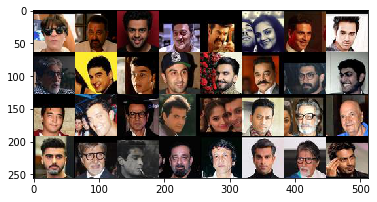

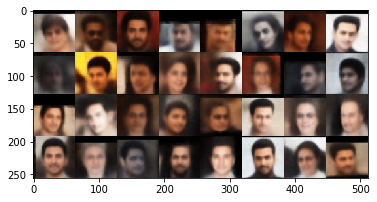

In [117]:
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    sample_batch = sample_batch[:32]

    sample_batch = sample_batch.to(device)
    sample_result, _, _ = vae(sample_batch)

    show_images(sample_batch)

    print()

    show_images(sample_result)